In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset
from prep_dataset import *
from train import get_logs

In [2]:
def config_filter(dic, param_names, param_values):
    for i, name in enumerate(param_names):
        if not(dic[name] == param_values[i]):
            return False
    return True

In [3]:
ds_name = "Synthie"
dataset, info = prep_dataset(ds_name)
n_features = info[0]
n_classes = info[1]

In [4]:
path = './logs'
test_logs, train_logs = get_logs(path)

In [5]:
configs = []
test_results = []
param_names = ['learning_rate', 'n_epochs', 'hidden_dim', 'dropout']
# Getting list of configs
test_logs = list(filter(lambda x: x["dataset"] == ds_name, test_logs))
train_logs = list(filter(lambda x: x["info_dict"]["dataset"] == ds_name, train_logs))
config_dicts = list(filter(lambda x: "GCNA" in x["model_name"], test_logs))
for dic in config_dicts:
    configs.append([dic.get(key) for key in param_names])

# Getting test results for each config
for config in configs:
    temp = []
    results = list(filter(lambda x: config_filter(x, param_names, config), test_logs))
    for res in results:
        temp.append([res["model_name"], res["Avg"], res["std"], res["max"]]) 
    test_results.append(temp)

for r in test_results:
    print(np.array(r))
    print()


[['GCNA' '54.4' '6.959885056522126' '65.0']
 ['GCN' '48.5' '5.852349955359813' '57.0']
 ['GINA' '50.2' '7.959899496852959' '62.0']
 ['GIN' '49.3' '7.457211275000863' '62.0']]



In [6]:
# Getting train logs for each config
training_logs = []
for config in configs:
    print(config)
    temp = []
    results = list(filter(lambda x: config_filter(x["info_dict"], param_names, config), train_logs))
    training_logs.append([res["log"] for res in results])

['0.001', '500', '128', '0.2']


In [7]:
def plot_learning_curves(train_log):
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    #fig.tight_layout()
    ax[0].grid()
    ax[1].grid()

    ax[0].plot(train_log[:, 0], train_log[:, 1])
    ax[0].set(xlabel="epochs", ylabel="loss")

    ax[1].set_ylim(bottom=0, top=100)
    ax[1].plot(train_log[:, 0], train_log[:, 2])
    ax[1].set(xlabel="epochs", ylabel="train_acc")
    #ax[1].legend()

    return fig, ax

def plot_training_acc(logs, n_folds):
    model_names = ['GCNA', 'GCN', 'GINA', 'GIN']
    for i in range(n_folds):
        fig = plt.figure(figsize=(15,5))
        fig.suptitle("Training Acc split no. {}".format(i+1))
        ax = plt.axes()
        ax.grid()
        ax.set(xlabel="epochs", ylabel="train_acc")
        ax.set_ylim(bottom=0, top=100)
        for log in logs:
            ax.plot(log[i, :, 0], log[i, :, 2])
            ax.legend(model_names)

## Class distribution of the dataset (Synthie):

Percentage of class 0: 23.25%
Percentage of class 1: 26.75%
Percentage of class 2: 27.50%
Percentage of class 3: 22.50%


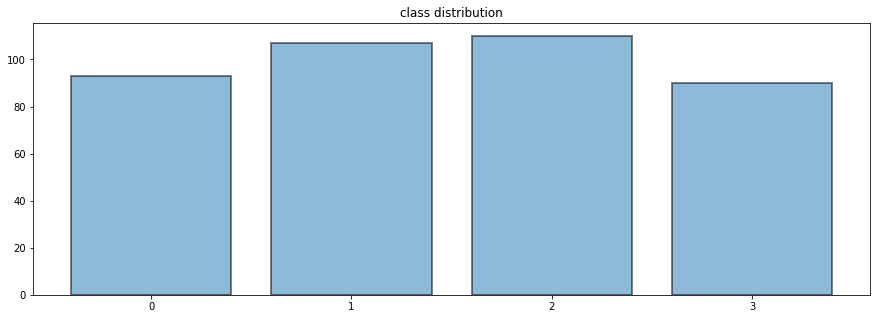

In [8]:
h_labels = dataset[:][2]
unique, counts = np.unique(h_labels.cpu(), return_counts=True)
###
for i, cl in enumerate(unique):
    print("Percentage of class {}: {:.2f}%".format(cl, 100*counts[i]/sum(counts)))
####
fig = plt.figure(figsize=(15,5))
ax = plt.axes()
ax.bar(unique, counts, align='center', alpha=0.5, edgecolor='black', linewidth=2)
ax.set_title("class distribution")
ax.set_xticks(unique)
plt.show()

### First set of hyperparameters:

- learning rate = 0.001 (lr decay = 0.8 every 50 epochs)
- number of epochs = 500
- hidden layers' dimension = 128
- dropout rate = 0.2
- number of gnn layers (GIN) = 2
- number of mlp layers (GIN) = 4

| Model | Avg. Accuracy |std| Max Accuracy |
|:-----:|:-------------:|:--:|:------------:|
|  GCN  |     48.5%     |5.85|     57.0%    |
|  GCNA |     54.4%     |6.96|     65.0%    |
|  GIN  |     49.3%     |7.46|     62.0%    |
|  GINA |     50.2%     |7.96|     62.0%    |


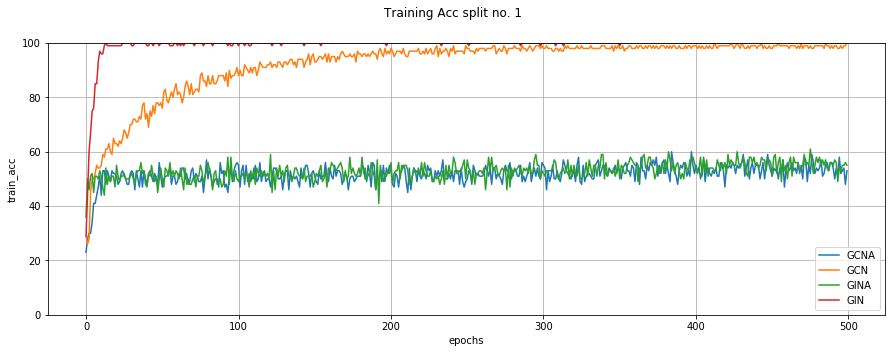

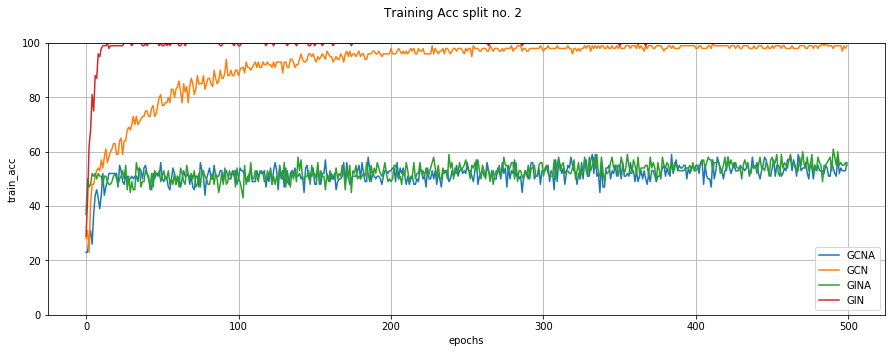

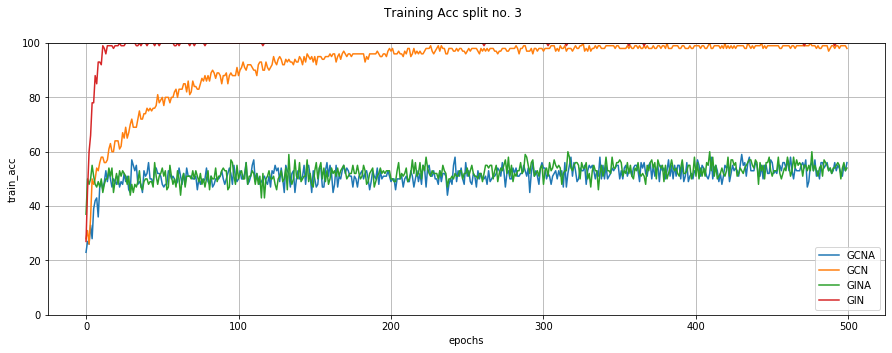

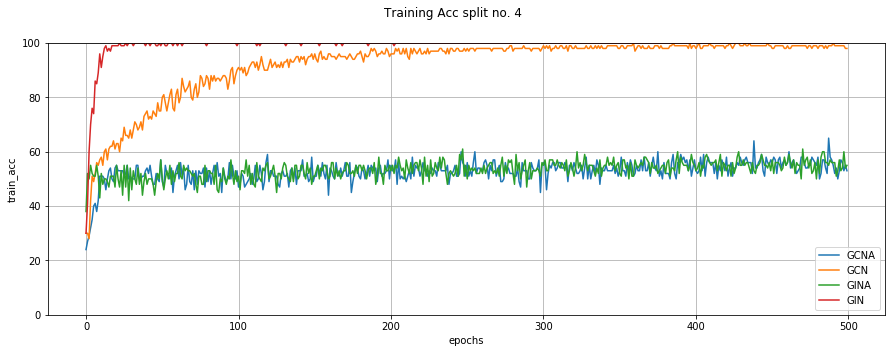

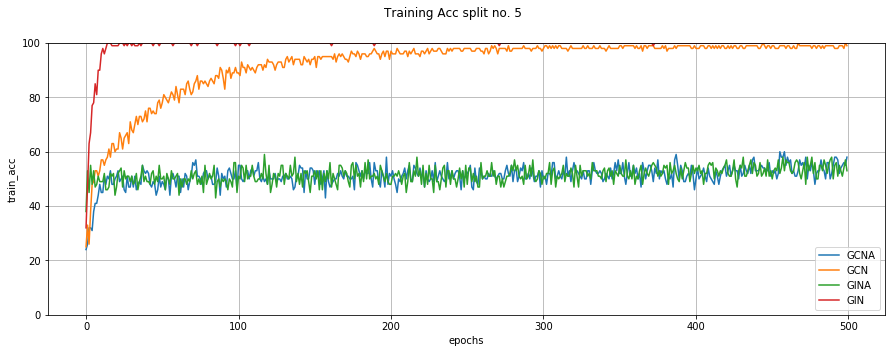

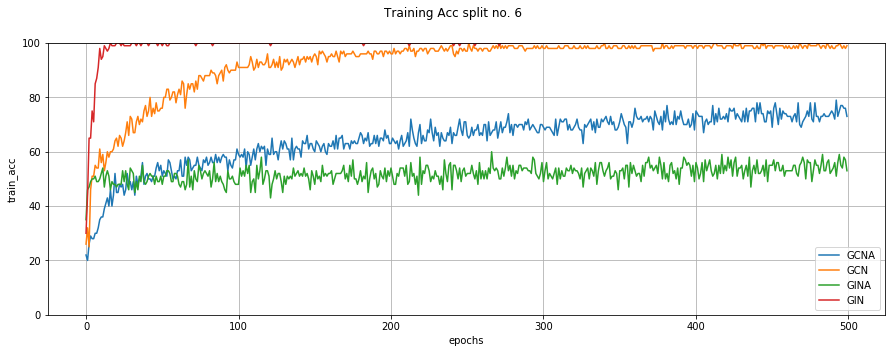

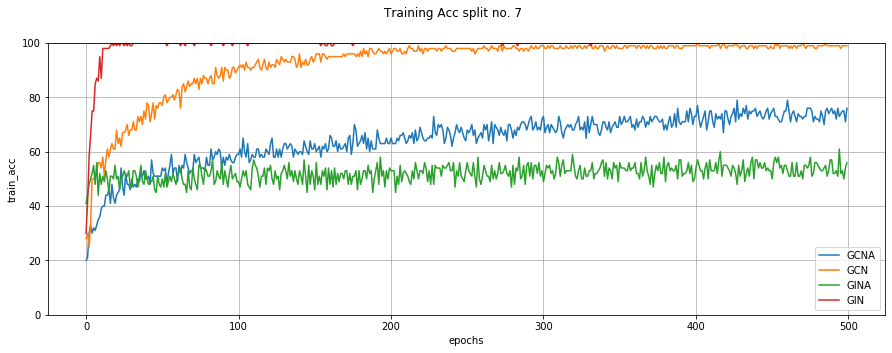

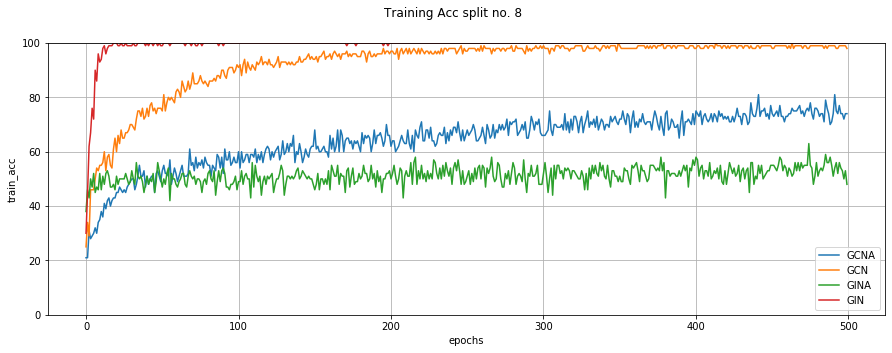

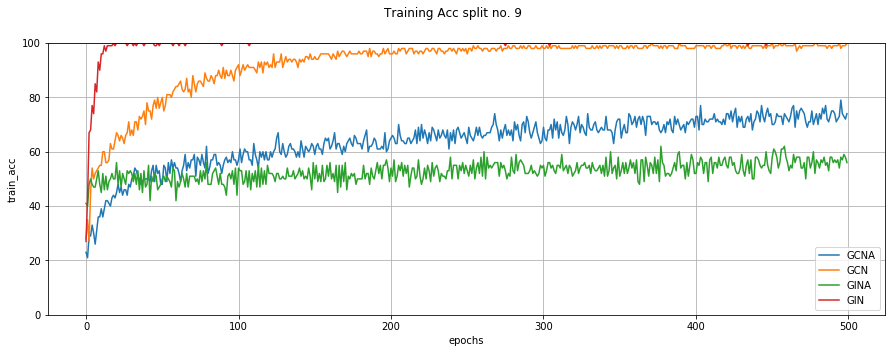

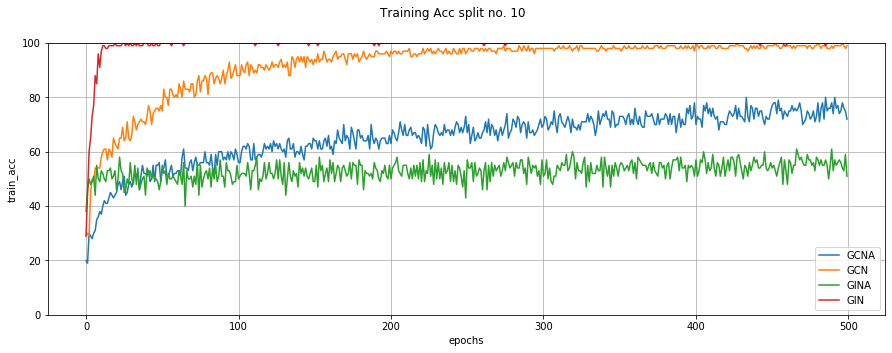

In [9]:
plot_training_acc(training_logs[0], 10)